In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from dask.diagnostics import ProgressBar
import time

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['font.size'] =30
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['legend.fontsize'] = 20 #30
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.major.pad']='8'
mpl.rcParams['ytick.major.pad']='8'


### Merges output to one netcdf per region

In [2]:
READING_DIR='out/run_CMIP6'

In [5]:
for REGION in ['16']:
    read_dir = os.path.join(READING_DIR, 'region_'+REGION,'*.nc')
    print(read_dir)
    with ProgressBar():
        ds = xr.open_mfdataset(read_dir, parallel=True)
        ds.to_netcdf(os.path.join(READING_DIR, REGION+'_equilibrium.nc'))
        print('region '+REGION+' DONE')

out/run_CMIP6/region_16/*.nc
[########################################] | 100% Completed | 31.4s
[########################################] | 100% Completed | 33.6s
region 16 DONE


In [6]:
ds

<xarray.Dataset>
Dimensions:           (rgi_id: 2484, gcm: 12, year: 133)
Coordinates:
  * rgi_id            (rgi_id) object 'RGI60-16.00001' ... 'RGI60-16.02945'
  * gcm               (gcm) object 'IPSL-CM5A2-INCA' 'E3SM-1-1' ... 'KACE-1-0-G'
  * year              (year) int64 1866 1867 1868 1869 ... 1995 1996 1997 1998
Data variables:
    equilibrium       (rgi_id, gcm, year) float64 dask.array<chunksize=(1, 12, 133), meta=np.ndarray>
    equilibrium_area  (rgi_id, gcm, year) float64 dask.array<chunksize=(1, 12, 133), meta=np.ndarray>
    run_time          (rgi_id, gcm, year) float64 dask.array<chunksize=(1, 12, 133), meta=np.ndarray>
Attributes:
    description:    OGGM model output
    oggm_version:   1.5.3.dev14+g25c4675
    calendar:       365-day no leap
    creation_date:  2021-12-17 19:51:29

In [ ]:
ds.to_netcdf(os.path.join(READING_DIR, REGION+'_equilibrium_delay.nc'))

## Read regional output

In [3]:
with ProgressBar():
    p = os.path.join(READING_DIR,'*_equilibrium.nc')
    all_ds = xr.open_mfdataset(p, parallel=True)

[########################################] | 100% Completed |  0.3s


In [4]:
# drop glaciers where all runs failed
all_ds = all_ds.dropna(dim='rgi_id',how='all')
#sort by gcm
all_ds = all_ds.sortby('gcm')

### Plot results

In [219]:
from matplotlib import colors
from cycler import cycler

color_list=[colors.to_rgb('#'+c) for c in ["264653","264653","264653","2a9d8f","2a9d8f","2a9d8f","2a9d8f","fac723","FB8B24","FB8B24","FB8B24","9A031E"]]
gcm_cmap = cmap = mpl.colors.ListedColormap(color_list[1:])
custom_cycler = cycler(color=gcm_cmap.colors)

15 3
16 3
18 2


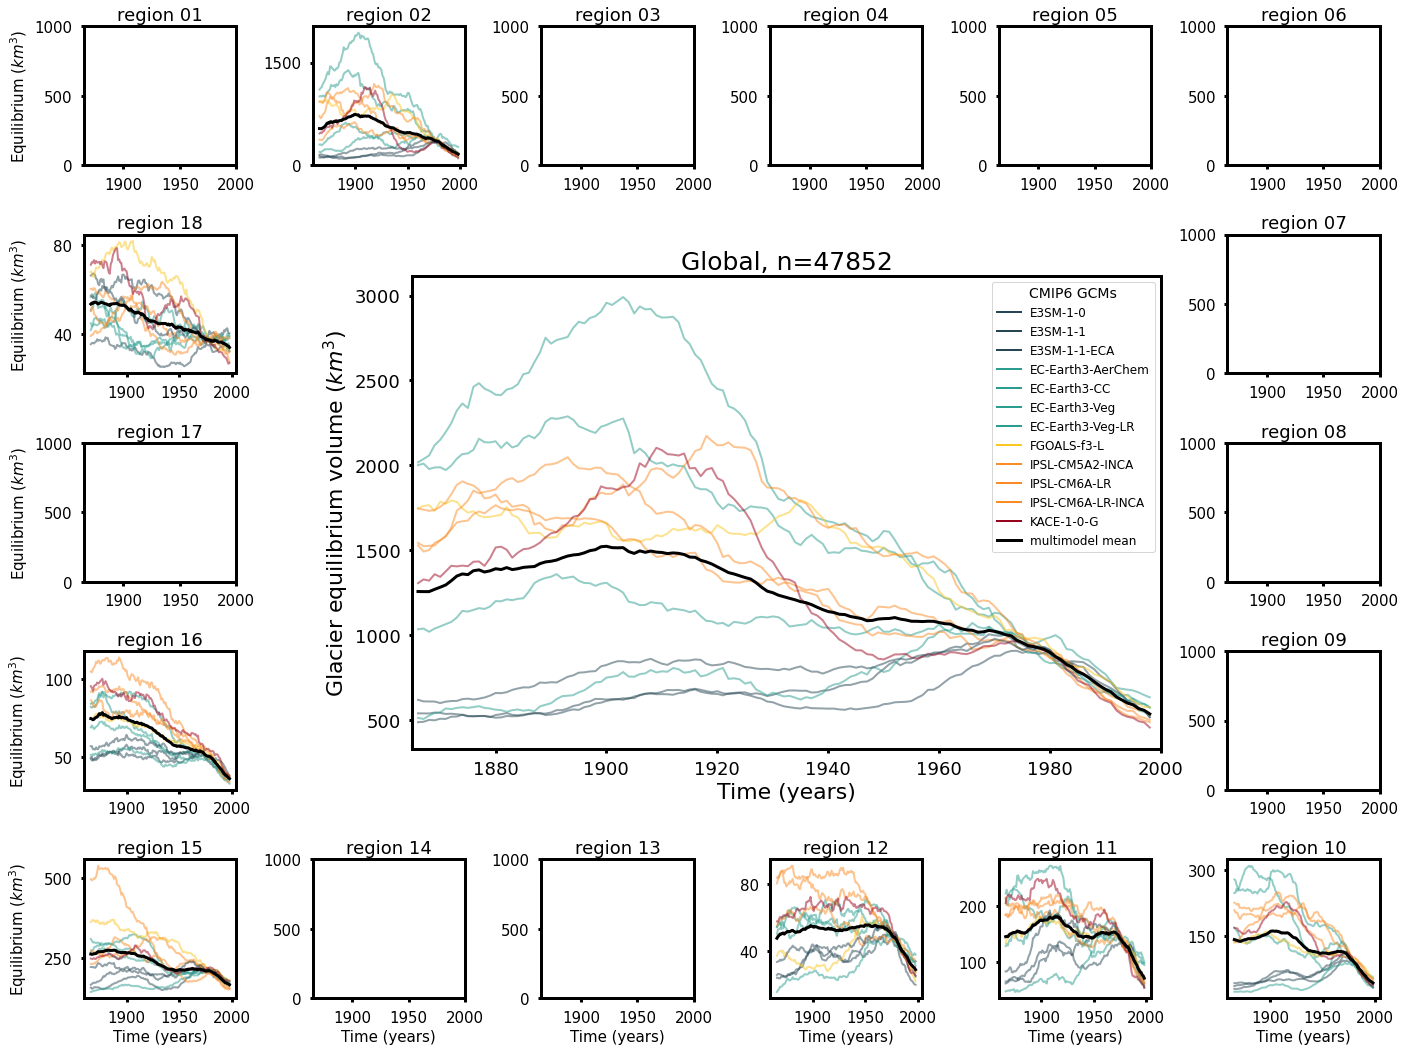

In [333]:
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(5,6, hspace=0.5, wspace=0.5,left=0.05,right=0.95,top=0.95,bottom=0.05)
grid2 = plt.GridSpec(20,24, hspace=1, wspace=0.5,left=0.05,right=0.95,top=0.95,bottom=0.05)

ax0 = fig.add_subplot(grid2[5:15,6:20])
ax0.set_prop_cycle(custom_cycler)
all_ds.equilibrium.drop_sel(gcm='E3SM-1-0').sum(dim='rgi_id').plot.line(hue='gcm',label=gcm.values,alpha=0.5,ax=ax0,lw=2);
all_ds.equilibrium.sel(gcm='E3SM-1-0',year=range(1866,1985)).sum(dim='rgi_id').plot.line(label='E3SM-1-0',alpha=0.5,ax=ax0,lw=2);

#calculate mean
all_ds.equilibrium.sel(year=range(1866,1985)).sum(dim='rgi_id').mean(dim='gcm').plot(color='k',ax=ax0)
all_ds.equilibrium.drop_sel(gcm='E3SM-1-0').sel(year=range(1984,1999)).sum(dim='rgi_id').mean(dim='gcm').plot(color='k',ax=ax0)

ax0.set_xlim(1865,2000)
ax0.set_ylabel(r'Glacier equilibrium volume ($km^3$)',size=22)
ax0.set_xlabel('Time (years)',size=22)
ax0.set_title('Global, n='+ str(len(all_ds.rgi_id)),size=25)
ax0.tick_params(axis='both', which='major', labelsize=18)

for i,grid_index in enumerate([0,1,2,3,4,5,11,17,23,29,28,27,26,25,24,18,12,6]):
    reg = str(i+1).zfill(2)
    ax = fig.add_subplot(grid[grid_index])
    sub = all_ds.where(all_ds.rgi_id.str.startswith('RGI60-'+reg),drop=True)
    if len(sub.rgi_id)>0:
        ax.set_prop_cycle(custom_cycler)
        sub.equilibrium.drop_sel(gcm='E3SM-1-0').sum(dim='rgi_id').plot.line(hue='gcm',label=gcm.values,alpha=0.5,ax=ax,add_legend=False,lw=2);
        sub.equilibrium.sel(gcm='E3SM-1-0',year=range(1866,1985)).sum(dim='rgi_id').plot.line(label=gcm.values,alpha=0.5,ax=ax,add_legend=False,lw=2);
        #calculate mean
        sub.equilibrium.sel(year=range(1866,1985)).sum(dim='rgi_id').mean(dim='gcm').plot(color='k',ax=ax)
        sub.equilibrium.drop_sel(gcm='E3SM-1-0').sel(year=range(1984,1999)).sum(dim='rgi_id').mean(dim='gcm').plot(color='k',ax=ax)
    else:
        ax.set_xlim(1865,2000)
        ax.set_ylim(0,1000)
        
    ax.set_title('region '+reg,size=18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.yaxis.set_major_locator(MaxNLocator(2)) 
    #ax.set_xticks([1900,2000])
    if 8<i<15:
        ax.set_xlabel('Time (years)',size=15)
    else:
        ax.set_xlabel('')
    if i==0 or i>13:
        pad=None
        if reg=='18':
            pad=23
            print(reg,'2')
        if reg=='16' or reg=='15':
            pad=15
            print(reg,'3')
        ax.set_ylabel(r'Equilibrium ($km^3$)',size=15,labelpad=pad)
    else:
        ax.set_ylabel('')

# legend
custom_lines = [Line2D([0], [0], color=cmap(0), lw=2)]+[Line2D([0], [0], color=cmap(i), lw=2) for i,gcm in enumerate(all_ds.drop_sel(gcm='E3SM-1-0').gcm)]+[Line2D([0], [0], color='k', lw=3)]
leg = ax0.legend(custom_lines, np.append(all_ds.gcm.values,'multimodel mean'),fontsize=12)
leg.set_title('CMIP6 GCMs',prop={'size':14})
plt.savefig(os.path.join('out','run_CMIP6','plots','global.png'),dpi=300)

In [ ]:
gcm_list=['E3SM-1-1-ECA']

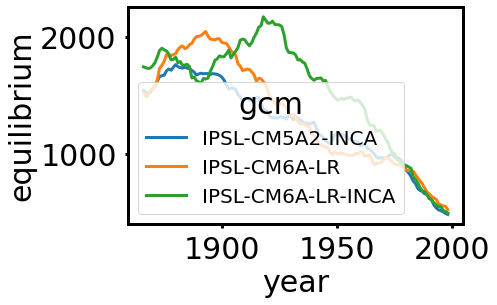

In [382]:
e3sm=None

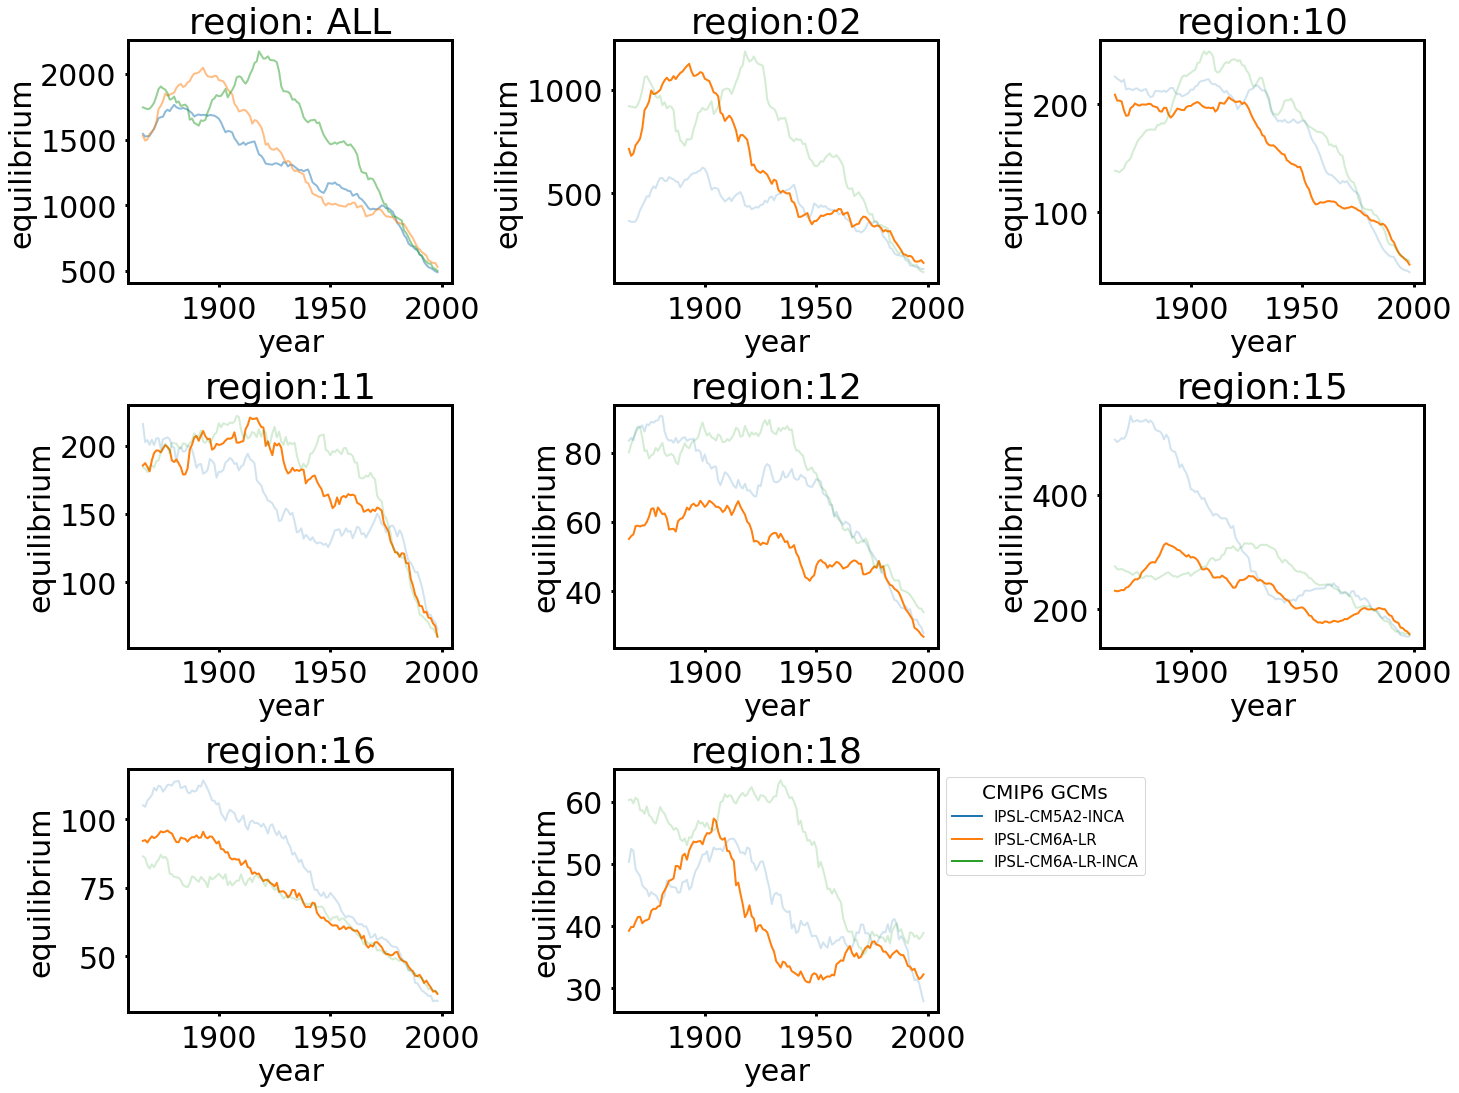

In [391]:
sel = all_ds.where(all_ds.gcm.str.startswith('IPSL'),drop=True)
sel_gcm='IPSL-CM6A-LR'

fig = plt.figure(figsize=(20,15))
grid = plt.GridSpec(3,3, hspace=0.5, wspace=0.5,left=0.05,right=0.95,top=0.95,bottom=0.05)

ax = fig.add_subplot(grid[0])
sel.equilibrium.sum(dim='rgi_id').plot.line(hue='gcm',label=gcm.values,alpha=0.5,ax=ax,lw=2,add_legend=False);
ax.set_title('region: ALL')


for i,reg in enumerate([2,10,11,12,15,16,18]):
    reg = str(reg).zfill(2)
    ax = fig.add_subplot(grid[i+1])
    sub = sel.where(sel.rgi_id.str.startswith('RGI60-'+reg),drop=True)
    for gcm in sub.gcm:
        if gcm==sel_gcm:
            alpha=1
        else:
            alpha=0.2
        sub.equilibrium.sel(gcm=gcm).sum(dim='rgi_id').plot.line(hue='gcm',label=gcm.values,alpha=alpha,ax=ax,lw=2,add_legend=False,);
    ax.set_title('region:'+reg)


custom_lines = [Line2D([0], [0], color=plt.get_cmap("tab10")(i), lw=2) for i,gcm in enumerate(sel.gcm)]
leg = ax.legend(custom_lines, np.append(sel.gcm.values,'multimodel mean'),fontsize=15,bbox_to_anchor=(1,1))
leg.set_title('CMIP6 GCMs',prop={'size':20})

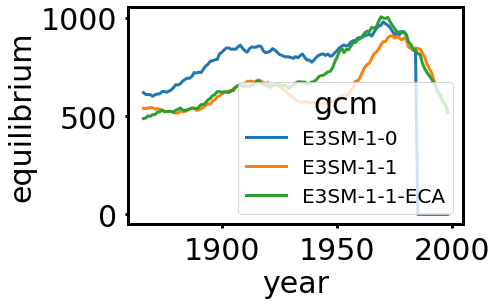

In [349]:
e3sm = all_ds.where(all_ds.gcm.str.startswith('E3SM'),drop=True)
e3sm.sum(dim='rgi_id').equilibrium.plot.line(hue='gcm');